In [1]:
import tensorflow as tf
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
np.random.seed(1)
import string     
from keras.layers import Embedding
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import one_hot
from keras.preprocessing import sequence
from tensorflow.keras.layers import LSTM
import keras
from keras.utils import to_categorical
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Using TensorFlow backend.


In [2]:
data = pd.read_csv("/Users/Riniperencsik/Desktop/Projects/Twitter Sentiment Analysis/twitter_airlines_data.csv", encoding= 'unicode_escape')

In [3]:
#separate the tweets based on their sentiment

data = data[['airline_sentiment', "text"]]
positive_tweets = list(data[data['airline_sentiment']=='positive']['text'])
negative_tweets = list(data[data['airline_sentiment']=='negative']['text'])
neutral_tweets = list(data[data['airline_sentiment']=='neutral']['text'])

In [4]:


# create test sets and training sets
# we want to keep the distribution of classes the same for both sets

neutral_train = neutral_tweets[:2480] # 2480 is 80% of the neutral tweets

negative_train = negative_tweets[:7343] # 7343 is 80% of the negative tweets

positive_train = positive_tweets[:1891] # 1891 is 80% of the positive tweets

train = positive_train + negative_train + neutral_train


labels_train = [] # create the labels for each tweet

for i in range(2480): # 0 for neutral
    labels_train.append(0)
    
for i in range(7343): # 1 for negative
    labels_train.append(1)
    
for i in range(1891): # 2 for positive
    labels_train.append(2)
    

In [5]:
neutral_test = neutral_tweets[2480:] # 20% of the neutral tweets

negative_test = negative_tweets[7343:] # 20% of the negative tweets

positive_test = positive_tweets[1891:] # 20% of the positive tweets

test = positive_test + negative_test + neutral_test


labels_test = [] # create the labels for each tweet

for i in range(2480, 3099): # 0 for neutral
    labels_test.append(0)
    
for i in range(7343, 9178): # 1 for negative
    labels_test.append(1)
    
for i in range(1891, 2363): # 2 for positive
    labels_test.append(2)

In [6]:
# convert to one hot vector so that it can be processed by RNN

labels_train = to_categorical(labels_train)

labels_test = to_categorical(labels_test)

Keras requires that the input data be integer encoded so that each words is represented by a unique integer. 

In [7]:
# convert the tweets to an integer encoded version  
# one_hot() creates hash of each word

# for training set
train_encoded = [one_hot(d,10000) for d in train]

# for test set
test_encoded = [one_hot(d, 10000) for d in test]

In [8]:
# keras prefers inputs vectroized and all the same length so we must pad

# find the maxmimum number of words in one tweet

largest = len(test_encoded[0])

for tweet in test_encoded:
    if len(tweet) > largest:
        largest = len(tweet)
        
print("The longest tweet has {:d} number of words".format(largest))

max_tweet_length = largest


train_encoded = sequence.pad_sequences(train_encoded, maxlen = max_tweet_length)

# repeat for test set

max_tweet_length = largest
test_encoded = sequence.pad_sequences(test_encoded, maxlen = max_tweet_length)

The longest tweet has 50 number of words


# Callbacks

The callbacks already being used: 
- BaseLogger: Callback that accumulates epoch average of metrics
- ProgbadLogger: Callback that prints metrics to stdout
- History: Callback that records events into a history object

In [9]:
# verbose 0: silent, doesnt show anything
# verbose 1: shows you progress bad
# verbose 2: shows one line per epoch

# check it out on keras, if u dont know how many epochs to do with model checkpoint, u can save on the best loss its ever seen or best validation accuracy its ever seen

# saves a model or weights at some interval so the model can be loaded later to continue training from the state saved

from keras.callbacks import ModelCheckpoint

mc = ModelCheckpoint(
    filepath = "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5", # what to put here?
    monitor = 'val_loss',
    verbose = 0,
    save_best_only = True, # least loss... as opposed to saving each model at the end of each epoch
    save_weights_only = True, #
    mode = 'min') # min bc we want to minimize loss. max is for val_acc


# stops training when a monitored metric has stopped improving

from keras.callbacks import EarlyStopping

es = EarlyStopping(
    monitor = 'val_loss', # monitor the loss
    min_delta = 0.01, # wait patience periods for it to do better by the min delta, if it does not then stops training
    patience = 2, # number of epochs with no improvement
    verbose = 1, 
    mode = 'min')

#from keras.callbacks import LearningRateScheduler

#lrs = LearningRateScheduler(lambda epoch: 1./epoch) # at the end of each epoch change the learning rate 


# reduce learning rate when a metric has stopped improving 

from keras.callbacks import ReduceLROnPlateau # hardly uses this

# models often benefit from reducing the learning rate once learning stagnates
rlrop = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 2, # if model does not see improvement by epsilon after 2 epochs then reduce the learning rate
    verbose = 0,
    mode = 'min',
    epsilon = 0.0001,
    cooldown = 2, # wait 2 epochs before monitoring the metrics again
    min_lr = 0 # minimum learning rate
 )

from keras.callbacks import TensorBoard
import datetime, os
# https://pythonprogramming.net/tensorboard-analysis-deep-learning-python-tensorflow-keras/
# allows to visualize training over time
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tb = TensorBoard(
    log_dir =logdir,
    histogram_freq = 1, # histogram computation
    write_graph = True, 
    write_images = False, 
    embeddings_freq = 100,
    embeddings_layer_names = None, 
    embeddings_metadata = None)

/Users/Riniperencsik/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '
/Users/Riniperencsik/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/tensorboard_v2.py:102: UserWarning: The TensorBoard callback does not support embeddings display when using TensorFlow 2.0. Embeddings-related arguments are ignored.
  warnings.warn('The TensorBoard callback does not support '


### Layer #1: Word Embeddings

Word embeddings provide a vector representation of words and their relative meanings. They can be learned from alternative text data and be resued in following models. There are carefully designed methods of learning word embeddings such as word2vec. Keras supports word embeddings through the embedding layer. Additionally, they can also be learned as part of fitting a Neural Network on text data. Through this layer, the position of a word within the vector space is learned from text and is based on the words that surround the word when it is used. The embedding layer is initialized with random weights and will learn an embedding for all the words. The output of this layer is a 2D vector with one embedding for each word in the input sequence of words. 

### Layer #2: LSTM

Simple RNNs suffer from the vanishing gradient problem where information from previous layers gets lost as the network deepens. An LSTM algorithm was created to avoid this problem by allowing the neural network to carry information across multiple steps. Additionally, an LSTM cell can determine what information to remove as well. Therefore, it can learn to recognize an important input and store it for the future while removing usless information.

## Dropout

The intuition behind the dropout layer is that any one feature cannot be relied on, so the weights must be spread out. Dropout randomly knocks out units in your network so it is as if on every iteration, you are working with a smaller neural network which should have a regularizing effect. If overfitting is a problem in a layer (when the layer has a lot of parameters), you can decrease the keep probability. The downside is that the cost function is less defined and harder to calculate. 

## Optimization: 

Momentum - If there is a large learning rate, it might overshoot the optimal value. Momentum smoothes out the steps of gradient descent and allows the algorithm to take a more straightforward path using moving averages. It almost always works better than without momentum and speeds up the algorithm.

RMSprop - Helps to speed up gradient descent. The net effect of this is that your updates in the vertical direction are divided by a much larger number so that helps dampen out the oscillations. 

Adam Optimization - combines momentum and RMSprop.

## Softmax Classification:

Softmax is a generalization of logistic regression that allows for multi-class predictions. Use it in the last layer to generate outputs. It outputs a probability for each class and th loss fucntion tries to make the correct probability as high as possible.

## Learning Rate Decay

Implemented a learning rate decay upon plateau earlier. This helps the problem of local optima. Gradient descent can get stuck in local optima. Plateaus can really slow down learning (which adam can help speed up) when the gradient is close to 0. It is unlikley to get stuck in a local optima so long as yu are training a lage n.

In [11]:
# model down here

model = keras.Sequential() # sequential groups a stack of layers

model.add(keras.layers.Embedding(10000, 16)) 

# dropout is a regularization technique that aims to reduce the complexity of the model to prevent overfitting
# with dropout, you randomly deactivate certain neurons, layer needs to be tuned
model.add(keras.layers.LSTM(256, dropout = 0.5))

# a dropout layer is a fully connected nn layer where each input node is connected to each output node
model.add(keras.layers.Dense(3, activation = "softmax")) # common to put dense layer before output

print(model.summary())

model.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"]) # look up optimizer and loss

fitModel = model.fit(train_encoded, 
                     labels_train, 
                     epochs =10, 
                     batch_size = 128, # not using full batch since num samples > 2000
                     validation_data = (test_encoded, labels_test), 
                     verbose = 1,
                    callbacks = [tb, mc, es, rlrop])

print(fitModel)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               279552    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 440,323
Trainable params: 440,323
Non-trainable params: 0
_________________________________________________________________
None


/Users/Riniperencsik/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 11714 samples, validate on 2926 samples
Epoch 1/10
11714/11714 [==============================] - 125s 11ms/step - loss: 0.8784 - accuracy: 0.6300 - val_loss: 0.8215 - val_accuracy: 0.6394
Epoch 2/10
11714/11714 [==============================] - 113s 10ms/step - loss: 0.7369 - accuracy: 0.6776 - val_loss: 0.7834 - val_accuracy: 0.6774
Epoch 3/10
11714/11714 [==============================] - 89s 8ms/step - loss: 0.6623 - accuracy: 0.7237 - val_loss: 0.7900 - val_accuracy: 0.6955
Epoch 4/10
11714/11714 [==============================] - 97s 8ms/step - loss: 0.5942 - accuracy: 0.7659 - val_loss: 0.7935 - val_accuracy: 0.7157
Epoch 00004: early stopping


In [12]:
# Find train and test accuracy
# train accuracy originally 0.91, test = 0.69

#after removing the recurrent unit drop out, test accuracy increased 2%
loss, accuracy = model.evaluate(train_encoded, labels_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(test_encoded, labels_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8119
Testing Accuracy:  0.7157


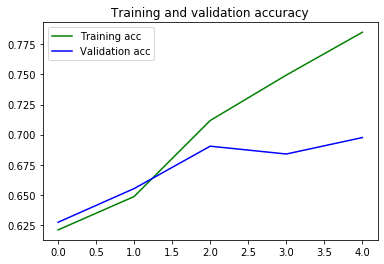

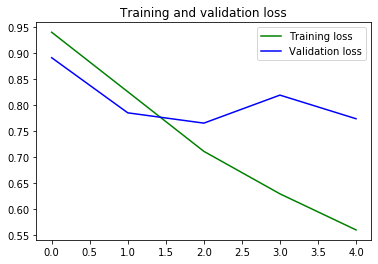

In [72]:
# Plot train/test loss and accuracy
acc = fitModel.history['accuracy']
val_acc = fitModel.history['val_accuracy']
loss = fitModel.history['loss']
val_loss = fitModel.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Model with Reduced Dimenstionality

In [13]:
# reduce dimensionality

model2 = keras.Sequential() # sequential groups a stack of layers

model2.add(keras.layers.Embedding(10000, 16)) 

# dropout is a regularization technique that aims to reduce the complexity of the model to prevent overfitting
# with dropout, you randomly deactivate certain neurons, layer needs to be tuned
model2.add(keras.layers.LSTM(64, dropout = 0.5))

# a dropout layer is a fully connected nn layer where each input node is connected to each output node
model2.add(keras.layers.Dense(3, activation = "softmax")) # common to put dense layer before output

print(model2.summary())

model2.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"]) # look up optimizer and loss

fitModel2 = model2.fit(train_encoded, 
                     labels_train, 
                     epochs =10, 
                     batch_size = 128, 
                     validation_data = (test_encoded, labels_test), 
                     verbose = 1,
                    callbacks = [tb, mc, es, rlrop])

print(fitModel2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 180,931
Trainable params: 180,931
Non-trainable params: 0
_________________________________________________________________
None


/Users/Riniperencsik/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 11714 samples, validate on 2926 samples
Epoch 1/10
11714/11714 [==============================] - 40s 3ms/step - loss: 0.8906 - accuracy: 0.6311 - val_loss: 0.8104 - val_accuracy: 0.6541
Epoch 2/10
11714/11714 [==============================] - 31s 3ms/step - loss: 0.7461 - accuracy: 0.6801 - val_loss: 0.8063 - val_accuracy: 0.6651
Epoch 3/10
11714/11714 [==============================] - 30s 3ms/step - loss: 0.6706 - accuracy: 0.7228 - val_loss: 0.7671 - val_accuracy: 0.6992
Epoch 4/10
11714/11714 [==============================] - 31s 3ms/step - loss: 0.5924 - accuracy: 0.7733 - val_loss: 0.7902 - val_accuracy: 0.7129
Epoch 5/10
11714/11714 [==============================] - 31s 3ms/step - loss: 0.5210 - accuracy: 0.8051 - val_loss: 0.7772 - val_accuracy: 0.7177
Epoch 00005: early stopping


In [14]:
# Find train and test accuracy
# train accuracy originally 0.91, test = 0.69
loss, accuracy = model2.evaluate(train_encoded, labels_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(test_encoded, labels_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

#test accuracy improved with dimenstionality deduction, although overfitting increased. must increase dropout percentage

Training Accuracy: 0.8463
Testing Accuracy:  0.7177


## Model with Increased Dropout Rate

In [16]:
# increase dropout
# reduce dimensionality

model3 = keras.Sequential() # sequential groups a stack of layers

model3.add(keras.layers.Embedding(10000, 16)) 

# dropout is a regularization technique that aims to reduce the complexity of the model to prevent overfitting
# with dropout, you randomly deactivate certain neurons, layer needs to be tuned
model3.add(keras.layers.LSTM(64, dropout = 0.65))

# a dropout layer is a fully connected nn layer where each input node is connected to each output node
model3.add(keras.layers.Dense(3, activation = "softmax")) # common to put dense layer before output

print(model3.summary())

model3.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"]) # look up optimizer and loss

fitModel3 = model3.fit(train_encoded, 
                     labels_train, 
                     epochs =10, 
                     batch_size = 128, 
                     validation_data = (test_encoded, labels_test), 
                     verbose = 1,
                    callbacks = [tb, mc, es, rlrop])

print(fitModel3)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                20736     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 195       
Total params: 180,931
Trainable params: 180,931
Non-trainable params: 0
_________________________________________________________________
None


/Users/Riniperencsik/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 11714 samples, validate on 2926 samples
Epoch 1/10
11714/11714 [==============================] - 36s 3ms/step - loss: 0.9182 - accuracy: 0.6247 - val_loss: 0.8267 - val_accuracy: 0.6381
Epoch 2/10
11714/11714 [==============================] - 30s 3ms/step - loss: 0.7725 - accuracy: 0.6649 - val_loss: 0.7931 - val_accuracy: 0.6702
Epoch 3/10
11714/11714 [==============================] - 33s 3ms/step - loss: 0.7011 - accuracy: 0.7089 - val_loss: 0.7983 - val_accuracy: 0.6883
Epoch 4/10
11714/11714 [==============================] - 30s 3ms/step - loss: 0.6424 - accuracy: 0.7446 - val_loss: 0.7888 - val_accuracy: 0.6941
Epoch 00004: early stopping


In [17]:
# Find train and test accuracy
# train accuracy originally 0.91, test = 0.69
loss, accuracy = model3.evaluate(train_encoded, labels_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model3.evaluate(test_encoded, labels_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

# test accuracy worsened as a result of increasing dropout rate

Training Accuracy: 0.7995
Testing Accuracy:  0.6941


## Model with Batch Normalization

Batch Normalization helps to speed up learning by making it so that the inputs take on a similar range of values. It makes hyperparameter search much easier, NN much more robust to the choice of hyperparamters, and easier to train.

In [33]:
# Batch Normalization

model3 = keras.Sequential() # sequential groups a stack of layers

model3.add(keras.layers.Embedding(10000, 16)) 

# dropout is a regularization technique that aims to reduce the complexity of the model to prevent overfitting
# with dropout, you randomly deactivate certain neurons, layer needs to be tuned
model3.add(keras.layers.LSTM(64, dropout = 0.5))

# a dropout layer is a fully connected nn layer where each input node is connected to each output node
model3.add(keras.layers.Dense(3))# common to put dense layer before output
model3.add(keras.layers.BatchNormalization())
model3.add(keras.layers.Activation('softmax'))

print(model3.summary())

model3.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"]) # look up optimizer and loss

fitModel3 = model3.fit(train_encoded, 
                     labels_train, 
                     epochs =10, 
                     batch_size = 128, 
                     validation_data = (test_encoded, labels_test), 
                     verbose = 1,
                    callbacks = [tb, mc, es, rlrop])

print(fitModel3)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                20736     
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 195       
_________________________________________________________________
batch_normalization_7 (Batch (None, 3)                 12        
_________________________________________________________________
activation_7 (Activation)    (None, 3)                 0         
Total params: 180,943
Trainable params: 180,937
Non-trainable params: 6
_________________________________________________________________
None


/Users/Riniperencsik/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 11714 samples, validate on 2926 samples
Epoch 1/10
11714/11714 [==============================] - 43s 4ms/step - loss: 0.9818 - accuracy: 0.5656 - val_loss: 1.0153 - val_accuracy: 0.6535
Epoch 2/10
11714/11714 [==============================] - 33s 3ms/step - loss: 0.8004 - accuracy: 0.6868 - val_loss: 0.9368 - val_accuracy: 0.7023
Epoch 3/10
11714/11714 [==============================] - 34s 3ms/step - loss: 0.6742 - accuracy: 0.7574 - val_loss: 0.9693 - val_accuracy: 0.5513
Epoch 4/10
11714/11714 [==============================] - 36s 3ms/step - loss: 0.5868 - accuracy: 0.7922 - val_loss: 0.8007 - val_accuracy: 0.6606
Epoch 5/10
11714/11714 [==============================] - 35s 3ms/step - loss: 0.5155 - accuracy: 0.8254 - val_loss: 0.7385 - val_accuracy: 0.7071
Epoch 6/10
11714/11714 [==============================] - 40s 3ms/step - loss: 0.4674 - accuracy: 0.8466 - val_loss: 0.8988 - val_accuracy: 0.6183
Epoch 7/10
11714/11714 [==============================] - 32s 3ms/ste

In [20]:
# Find train and test accuracy
# train accuracy originally 0.91, test = 0.69
loss, accuracy = model3.evaluate(train_encoded, labels_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model3.evaluate(test_encoded, labels_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
# test accuracy worsened as a result of batch normalization

Training Accuracy: 0.9200
Testing Accuracy:  0.6921


## Model with Batch Normalization after Activation Layer - NaN Loss 

In [25]:
# Batch Normalization

model4 = keras.Sequential() # sequential groups a stack of layers

model4.add(keras.layers.Embedding(10000, 16)) 

# dropout is a regularization technique that aims to reduce the complexity of the model to prevent overfitting
# with dropout, you randomly deactivate certain neurons, layer needs to be tuned
model4.add(keras.layers.LSTM(64, dropout = 0.5))

# a dropout layer is a fully connected nn layer where each input node is connected to each output node
model4.add(keras.layers.Dense(3))# common to put dense layer before output
model4.add(keras.layers.Activation('softmax'))
model4.add(keras.layers.BatchNormalization())


print(model4.summary())

model4.compile(optimizer = "adam", loss = "categorical_crossentropy", metrics = ["accuracy"]) # look up optimizer and loss

fitModel4 = model4.fit(train_encoded, 
                     labels_train, 
                     epochs =10, 
                     batch_size = 128, 
                     validation_data = (test_encoded, labels_test), 
                     verbose = 1,
                    callbacks = [tb, mc, es, rlrop])

print(fitModel4)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 16)          160000    
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                20736     
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 195       
_________________________________________________________________
activation_6 (Activation)    (None, 3)                 0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 3)                 12        
Total params: 180,943
Trainable params: 180,937
Non-trainable params: 6
_________________________________________________________________
None


/Users/Riniperencsik/opt/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 11714 samples, validate on 2926 samples
Epoch 1/10
11714/11714 [==============================] - 51s 4ms/step - loss: nan - accuracy: 0.2162 - val_loss: nan - val_accuracy: 0.2116


InvalidArgumentError: Nan in summary histogram for: embedding_10/embeddings_0 [Op:WriteHistogramSummary] name: embedding_10/embeddings_0/

In [23]:
# Find train and test accuracy
# train accuracy originally 0.91, test = 0.69
loss, accuracy = model4.evaluate(train_encoded, labels_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model4.evaluate(test_encoded, labels_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.2117
Testing Accuracy:  0.2116


In [1]:
#%tensorboard --logdir logs

In [66]:
%load_ext tensorboard


## Up Next:

- High Bias: bigger network, train longer, more advanced optimization algorithms
- Mini batch size
- Learning rate: try a range of values for alpha
- Number of layers
